# Multicollinearity in Asset Pricing Models Using Indian Data: A Primer

## Introduction

In a multiple regression model, multicollinearity occurs when two or more predictor variables (right-hand side variables) exhibit high correlation. This effect makes it difficult to isolate the individual impact of each predictor on the dependent variable. In asset pricing and factor models, multicollinearity can lead to unreliable estimates of factor loadings, which are crucial for understanding the relationship between risk factors and asset returns.

Addressing multicollinearity in multivariate asset pricing models, like the Fama-French three-factor and five-factor models, is a key step in improving their accuracy and reliability. These models, where multiple predictors (risk factors) often show high correlations due to overlapping information or economic relationships, are widely used to explain the returns of financial portfolios.

In India, many analysts use publicly available strategy indices as predictor variables. In this notebook, we will explore the issue of multicollinearity in asset pricing models using Indian financial data and demonstrate how to identify and mitigate multicollinearity, enhancing the robustness and interpretability of analyses.


## Import Libraries

In [ ]:
# Install required libraries (this is only necessary 
# if running in an environment that does not automatically handle 
# requirements.txt)
!pip install indiafactorlibrary


In [85]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

## Load Files

We will use a CSV file named 'nifty_indices_rets_example.csv', which contains monthly returns for several popular Nifty indices. These indices are:

- **Nifty 500**: Represents the total market.
- **Nifty 200**: Represents large and mid-cap stocks.
- **Nifty Smallcap 100**: Represents small-cap stocks.
- **Nifty 500 Value 50**: Represents value-style stocks.
- **Nifty 200 Quality 30**: Represents quality-style stocks.
- **Nifty 200 Momentum 30**: Represents momentum-style stocks.
- **Nifty 100 Low Volatility 30**: Represents low-volatility stocks.

Analysts commonly use these indices as proxies for various market segments and investment styles.

The data in the CSV file is derived from daily Net Asset Values (NAVs) converted to monthly returns. The original data was sourced from ABSL AMC. For more details on the data and methodology, refer to the [Additional Data on Quant Model](https://mutualfund.adityabirlacapital.com/market-update).


In [86]:
# URL of the CSV file on GitHub
url = 'https://raw.githubusercontent.com/rraju26/pyIndiaFactorInvesting/main/data/nifty_indices_rets_example.csv'
# Local file path
file_path = 'data/nifty_indices_rets_example.csv'
# Try to read the CSV file from the local directory, fallback to URL if it fails
try:
    nifty_styles = pd.read_csv(file_path, index_col='Dates', parse_dates=['Dates'])
except FileNotFoundError:
    nifty_styles = pd.read_csv(url, index_col='Dates', parse_dates=['Dates'])
nifty_styles.head().round(2)

,NIFTY_500,NIFTY_200,NIFTY_SMALLCAP_100,NIFTY500_VALUE_50,NIFTY200_QUALITY_30,NIFTY200_MOMENTUM_30,NIFTY100_LOW_VOLATILITY_30
Dates,,,,,,,
2005-05-31,0.09,0.09,0.09,0.10,0.08,0.10,0.09
2005-06-30,0.04,0.05,0.01,-0.02,0.06,0.04,0.05
2005-07-31,0.07,0.06,0.12,0.12,0.04,0.09,0.07
2005-08-31,0.05,0.04,0.15,0.06,0.03,0.00,0.06
2005-09-30,0.07,0.08,0.02,0.04,0.09,0.09,0.07


The returns of these indices are highly correlated.

In [87]:
nifty_styles=nifty_styles.astype(float)
nifty_styles.corr().round(2)

,NIFTY_500,NIFTY_200,NIFTY_SMALLCAP_100,NIFTY500_VALUE_50,NIFTY200_QUALITY_30,NIFTY200_MOMENTUM_30,NIFTY100_LOW_VOLATILITY_30
NIFTY_500,1.00,1.00,0.91,0.89,0.92,0.89,0.93
NIFTY_200,1.00,1.00,0.89,0.87,0.93,0.89,0.93
NIFTY_SMALLCAP_100,0.91,0.89,1.00,0.90,0.81,0.79,0.81
NIFTY500_VALUE_50,0.89,0.87,0.90,1.00,0.75,0.74,0.77
NIFTY200_QUALITY_30,0.92,0.93,0.81,0.75,1.00,0.86,0.94
NIFTY200_MOMENTUM_30,0.89,0.89,0.79,0.74,0.86,1.00,0.87
NIFTY100_LOW_VOLATILITY_30,0.93,0.93,0.81,0.77,0.94,0.87,1.00


## Fetch and Read the example file of Monthly Returns into a DataFrame
Read the Fund monthly returns into a pandas DataFrame.


In [88]:
# URL of the CSV file on GitHub
url = 'https://raw.githubusercontent.com/rraju26/pyIndiaFactorInvesting/main/data/fba_sample_data.csv'

# Local file path
file_path = 'data/fba_sample_data.csv'

# Try to read the CSV file from the local directory, fallback to URL if it fails
try:
    fund_returns = pd.read_csv(file_path, index_col='Dates', parse_dates=['Dates'])/100
except FileNotFoundError:
    fund_returns = pd.read_csv(url, index_col='Dates', parse_dates=['Dates'])/100

print(fund_returns.head(10))

            sample_fund
Dates                  
2013-01-31     -0.00745
2013-02-28     -0.02495
2013-03-31      0.01631
2013-04-30      0.06336
2013-05-31      0.04082
2013-06-30     -0.03347
2013-07-31      0.00066
2013-08-31     -0.04204
2013-09-30      0.06615
2013-10-31      0.07126


## Concatenate Returns with Style Indices

### Introduction to Regression with Style Indices

In this section, we will demonstrate how an analyst might regress fund returns against style indices to show factor exposure. An example of such a regression model is:

$ r_{fund} = \alpha + \beta_{mkt} r_{Nifty500} + \beta_v r_{Nifty500Value50} + \beta_q r_{Nifty200Quality30} + \beta_m r_{Nifty200Momentum30} $

Here, $ r_{fund} $ represents the returns of the fund, while $ r_{Nifty500} $, $ r_{Nifty500Value50} $, $ r_{Nifty200Quality30} $, and $ r_{Nifty200Momentum30} $ represent the returns of the respective Nifty indices. The coefficients $\beta_{mkt}$, $\beta_v$, $\beta_q$, and $\beta_m$ measure the exposure of the fund to these indices. 

**Note:** Unlike CAPM or other asset pricing models, the model does not subtract risk-free rates.

Let's start with a basic regression model that is likely to contain errors.





In [89]:
# Concatenate excess returns with Fama-French 6 factors dataset
fund_df = pd.concat([fund_returns, nifty_styles[['NIFTY_500', 'NIFTY_200', 'NIFTY500_VALUE_50', 'NIFTY200_QUALITY_30', 'NIFTY200_MOMENTUM_30']]], axis=1).dropna()
print(fund_df)

            sample_fund  NIFTY_500  NIFTY_200  NIFTY500_VALUE_50  \
Dates                                                              
2013-01-31     -0.00745       0.01       0.01              -0.02   
2013-02-28     -0.02495      -0.07      -0.06              -0.16   
2013-03-31      0.01631      -0.01      -0.01              -0.04   
2013-04-30      0.06336       0.05       0.05               0.09   
2013-05-31      0.04082       0.01       0.01              -0.05   
...                 ...        ...        ...                ...   
2024-01-31      0.06771       0.02       0.01               0.08   
2024-02-29      0.03495       0.02       0.02               0.03   
2024-03-31      0.01002       0.01       0.01               0.01   
2024-04-30      0.07654       0.04       0.03               0.11   
2024-05-31     -0.03546       0.01       0.01               0.01   

            NIFTY200_QUALITY_30  NIFTY200_MOMENTUM_30  
Dates                                                  
201

## Perform Linear Regression and Print Summary
We will perform a linear regression analysis using the model and print the regression summary.

In [90]:
# Perform linear regression using statsmodels
regression = smf.ols('sample_fund ~ NIFTY_500 + NIFTY500_VALUE_50 + NIFTY200_QUALITY_30 + NIFTY200_MOMENTUM_30', data=fund_df).fit()

# Print the regression summary
print(regression.summary())


                            OLS Regression Results                            
Dep. Variable:            sample_fund   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     296.5
Date:                Sat, 06 Jul 2024   Prob (F-statistic):           6.69e-65
Time:                        14:02:23   Log-Likelihood:                 378.67
No. Observations:                 137   AIC:                            -747.3
Df Residuals:                     132   BIC:                            -732.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0029 

## Regression Analysis for the Sample Fund's Returns
The regression analysis for the sample fund's returns with an R-squared of 0.900 suggests a robust model fit. It shows that the fund's returns are explained by the market (NIFTY 500) and momentum (NIFTY 200 Momentum 30) indices, which have t-statistics over 3.5 (see other notebooks in this repository for why 3.5). If the analyst concludes that the fund is a momentum low-beta fund based on these results, is she correct?

Upon closer examination, a significant issue surfaces. The market beta is surprisingly low at 0.33, suggesting that when the market moves by 1%, the fund will only move by a third. This contradicts the expected higher betas in momentum strategies. This discrepancy indicates that a further look is needed.

The diagnostics of residuals in the bottom panel of the results show that the residuals are not normally distributed. Specifically, the Omnibus and Jarque-Bera (JB) tests indicate significant non-normality as their p-values are zero. The Omnibus test checks for skewness and kurtosis in the residuals, while the Jarque-Bera test combines these two aspects to assess the goodness-of-fit of the residuals to a normal distribution. For these tests, values close to 0 indicate normality. P-values for the Omnibus and the JB test statistic above 0.05 suggest that the residuals are normally distributed with 95% confidence.

## Visualising Residuals
We use the histogram of residuals to understand the residuals better and identify any potential issues with our regression model. This plot helps us visualise the residuals' distribution and assess whether they follow a normal distribution. Ideally, residuals should follow a normal distribution centred around zero. However, as seen in the histogram, the residuals show some deviation from normality, suggesting potential issues with the model fit and implying that the analyst's conclusions may not be accurate.

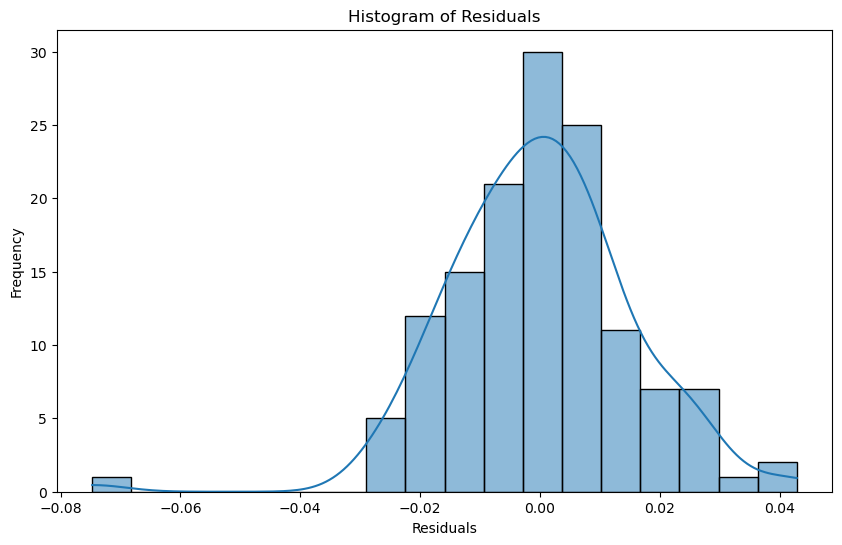

In [91]:
residuals = regression.resid

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## Multicollinearity and VIF
As seen above, the explanatory variables are highly correlated, which affects coefficient accuracy. 

A further test is the Variance Inflation Factor test. This is a widely used method that calculates a score for each independent variable. A VIF of 1 indicates no multicollinearity, while values greater than 5 (or sometimes 10) suggest potential issues. Higher VIF values imply an independent variable can be largely explained by a linear combination of other independent variables, making its individual coefficient estimate less reliable. Most statistical software packages can calculate VIFs.







In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Extract the independent variables from the fitted model
X = fund_df[['NIFTY_500', 'NIFTY500_VALUE_50', 'NIFTY200_QUALITY_30', 'NIFTY200_MOMENTUM_30']]
#calculate VIF for each explanatory variable
vifs = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                   index=[X.columns], columns=['VIF'])

print(vifs.round(2))

                        VIF
NIFTY_500             11.82
NIFTY500_VALUE_50      4.58
NIFTY200_QUALITY_30    5.19
NIFTY200_MOMENTUM_30   4.84


The VIF values shows clear evidence of multicollinearity for the model. This needs to be addressed. Dropping Nifty 500, the proxy for the market factor, entirely would clearly make the model irrelevant. What about replacing it with Nifty 200?

In [93]:
# Extract the independent variables from the fitted model
X = fund_df[['NIFTY_200', 'NIFTY500_VALUE_50', 'NIFTY200_QUALITY_30', 'NIFTY200_MOMENTUM_30']]
#calculate VIF for each explanatory variable
vifs = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                   index=[X.columns], columns=['VIF'])

print(vifs.round(2))

                        VIF
NIFTY_200             10.05
NIFTY500_VALUE_50      4.00
NIFTY200_QUALITY_30    5.42
NIFTY200_MOMENTUM_30   4.60


Replacing Nifty 500 with Nifty 200 does not solve the multicollinearity problem satistfactorily, as its VIF is above 10. Most analysis which use indices as proxies for factors should be viewed with caution due to this issue.

## Advanced Techniques for Addressing Multicollinearity
While this notebook focuses on the basics of identifying and understanding multicollinearity in asset pricing models using Indian financial data, several advanced techniques can be employed to address this issue. These include variable selection methods like backward elimination and forward selection, which help systematically choose the most relevant predictors. Principal Component Analysis (PCA) is another powerful tool that transforms correlated predictors into a set of uncorrelated components, thereby reducing dimensionality and multicollinearity. Additionally, regularisation methods such as Ridge and Lasso regression add penalty terms to the regression equation, helping mitigate multicollinearity by shrinking or eliminating some coefficients. While these techniques offer sophisticated solutions to multicollinearity, they are beyond the scope of this beginner's guide. Exploring these methods can provide more robust and refined models but requires a more advanced statistical background.

## Using an academic Asset Pricing Model (APM)
Academic APMs are constructed to avoid the multicollinearity problem, and therefore, are better suited for using regression and other statistical techniques to explain returns.

We will use the `IndiaFactorLibrary` to read the Fama-French 6 factors dataset from Invespar "Data Library: Fama-French Factors, Momentum, and Low-Risk Factors for the Indian Market" available at https://www.invespar.com/research.


In [94]:
from indiafactorlibrary import IndiaFactorLibrary

# Initialize the IndiaFactorLibrary
ifl = IndiaFactorLibrary()

# Read the Fama-French 6 factors dataset
ff6 = ifl.read('ff6')[0]/100
print(ff6)

                  MF      SMB5       HML       RMW       CMA       WML  \
Dates                                                                    
2004-10-31  0.012168 -0.006080 -0.020792  0.023774 -0.028868  0.027795   
2004-11-30  0.094784  0.033578  0.010583  0.045068 -0.016372  0.016852   
2004-12-31  0.089490  0.043343  0.043104  0.020992  0.023392 -0.037736   
2005-01-31 -0.019222  0.000250 -0.014563  0.019196 -0.010112  0.023761   
2005-02-28  0.032679  0.030760  0.047830 -0.013918 -0.008232  0.028335   
...              ...       ...       ...       ...       ...       ...   
2024-01-31  0.037383  0.048908  0.060960 -0.045838  0.032928  0.071994   
2024-02-29  0.014083 -0.030371 -0.012132  0.001622  0.005138  0.011601   
2024-03-31 -0.009468 -0.072897  0.002156  0.000868 -0.017741  0.010147   
2024-04-30  0.041428  0.072149  0.034824 -0.016815  0.008483  0.030944   
2024-05-31  0.005197 -0.048571 -0.014302  0.017060  0.005262  0.010092   

                  RF       MKT  
Date

## Concatenate Returns with Fama-French 6 Factors Dataset
We will concatenate the example fund returns with the Fama-French 6 factors dataset for India.
**Note** We are still using raw returns.

In [103]:
# Concatenate returns with Fama-French 6 factors dataset
fund_df_apm = pd.concat([fund_returns, ff6[['MF', 'SMB5', 'HML', 'RMW', 'CMA', 'WML']]], axis=1).dropna()
print(fund_df_apm)

            sample_fund        MF      SMB5       HML       RMW       CMA  \
Dates                                                                       
2013-01-31     -0.00745  0.007448 -0.031895 -0.042488  0.010954 -0.000078   
2013-02-28     -0.02495 -0.075909 -0.038411 -0.081948  0.051298 -0.026902   
2013-03-31      0.01631 -0.027063 -0.039798 -0.038876  0.069282 -0.043362   
2013-04-30      0.06336  0.034903 -0.005365  0.018054 -0.042462  0.037902   
2013-05-31      0.04082  0.000382 -0.003801 -0.106470  0.027881 -0.014588   
...                 ...       ...       ...       ...       ...       ...   
2024-01-31      0.06771  0.037383  0.048908  0.060960 -0.045838  0.032928   
2024-02-29      0.03495  0.014083 -0.030371 -0.012132  0.001622  0.005138   
2024-03-31      0.01002 -0.009468 -0.072897  0.002156  0.000868 -0.017741   
2024-04-30      0.07654  0.041428  0.072149  0.034824 -0.016815  0.008483   
2024-05-31     -0.03546  0.005197 -0.048571 -0.014302  0.017060  0.005262   

In [104]:
# Perform linear regression using statsmodels
regression = smf.ols('sample_fund ~ MF + SMB5 + HML + RMW + CMA + WML', data=fund_df_apm ).fit()

# Print the regression summary
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:            sample_fund   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     162.1
Date:                Sat, 06 Jul 2024   Prob (F-statistic):           7.66e-58
Time:                        14:06:29   Log-Likelihood:                 367.50
No. Observations:                 137   AIC:                            -721.0
Df Residuals:                     130   BIC:                            -700.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0080      0.002      5.069      0.0

## Interpreting the Better Model Results (but still with one error)
The regression analysis for the sample fund's returns using the corrected model shows improved diagnostics and more reliable results. The R-squared value is 0.882, indicating that 88.2% of the variability in the fund's returns is explained by the model.

Examining the coefficients, we find that the intercept is small but statistically significant ($t$-statistic of 5), suggesting a minor outperformance over the academic APM. The market factor (MF) coefficient is 1.02, highly significant with a $t$-statistic of 25.632, reflecting the substantial impact of market movements on the fund's returns. This is more intuitive. The size factor (SMB5) is also significant, with a positive coefficient of 0.17, indicating the fund's exposure to mid/smaller companies. The value factor (HML) is not significant, suggesting that value does not meaningfully impact the fund's returns. The momentum factor (WML) is highly significant with a positive coefficient of 0.28, reflecting the fund's strong exposure to momentum stocks.

The residual diagnostics show that the residuals are now normally distributed, as indicated by the Omnibus and Jarque-Bera tests, both with statistics less than 5. This indicates that the residuals are centered around zero with no significant skewness or kurtosis, confirming the model's appropriateness.


In [109]:
# Extract the independent variables from the fitted model
X = fund_df_apm[['MF', 'SMB5', 'HML','RMW','CMA','WML']]
#calculate VIF for each explanatory variable
vifs = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                   index=[X.columns], columns=['VIF'])

print(vifs.round(2))

       VIF
MF    1.71
SMB5  1.38
HML   3.36
RMW   2.35
CMA   1.33
WML   1.26


The VIFs are also well behaved - under 5. Overall, the improved diagnostics and the lack of significant multicollinearity (evidenced by the significance of multiple predictors and the normality of residuals) suggest that this model is robust and reliable. The significant coefficients for market, size, and momentum factors provide meaningful insights into the fund's exposures.

Is this therefore done? No, we still have to run the analysis on excess returns rather than raw returns. And that should reduce the intercept term.

## The Model Corrected for Excess Returns

In asset pricing and financial modeling, risk-free rates play an important role in assessing investment performance. The risk-free rate represents the return on an investment with zero risk, such as short-term government bonds. This rate serves as a benchmark to evaluate the additional return, or "premium," that investors expect for taking on risk beyond the risk-free rate. The [Invespar Data Library](http://invespar.com/research) provides monthly risk-free rates calculated from the Reserve Bank of India's weekly auction of 91-day Treasury Bills.

Adjusting fund returns by subtracting the risk-free rate helps calculate the "excess return," which is the return attributable to the specific risks of the investment, excluding the return that could have been earned without taking on any risk. For example, if a fund has a return of 8% and the risk-free rate is 3%, the excess return is 5%. This adjustment allows for a more accurate comparison of performance across different investments on a risk-adjusted basis.

In models like the Capital Asset Pricing Model (CAPM) and other multifactor models, the risk-free rate is used to determine the expected return on an investment based on its systematic risk (beta). These models aim to quantify the excess return over the risk-free rate attributable to various risk factors.

Subtracting the risk-free rate from the strategy's returns allows for the more accurate calculation of outperformance (alpha) and sensitivity to factors (betas) and therefore, in evaluating performance. Alpha represents the strategy's performance beyond what is predicted by its beta, indicating the manager's skill, while beta measures the sensitivity of the strategy's returns to the market. For example, if a fund's beta is 1.2, it is expected to be 20% more volatile than the market.

In summary, using risk-free rates and adjusting raw returns accordingly provides a clearer picture of the returns generated by taking on additional risk. It isolates the excess returns attributable to various risk factors, allowing for better comparison and evaluation of investment performance.


In [110]:
# Subtract risk-free rate to get excess returns, and drop NaN values
fund_excess = fund_returns.sub(ff6['RF'], axis=0).dropna()
print('Excess Returns:')
print(fund_excess.head(10))

Excess Returns:
            sample_fund
Dates                  
2013-01-31    -0.014736
2013-02-28    -0.031243
2013-03-31     0.010260
2013-04-30     0.057185
2013-05-31     0.034392
2013-06-30    -0.039324
2013-07-31    -0.006805
2013-08-31    -0.050780
2013-09-30     0.057755
2013-10-31     0.063811


In [111]:
# Concatenate returns with Fama-French 6 factors dataset
fund_df_apm1 = pd.concat([fund_excess, ff6[['MF', 'SMB5', 'HML', 'RMW', 'CMA', 'WML']]], axis=1).dropna()
# Perform linear regression using statsmodels
regression = smf.ols('sample_fund ~ MF + SMB5 + HML + RMW + CMA + WML', data=fund_df_apm1 ).fit()

# Print the regression summary
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:            sample_fund   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     167.1
Date:                Sat, 06 Jul 2024   Prob (F-statistic):           1.37e-58
Time:                        14:08:28   Log-Likelihood:                 369.11
No. Observations:                 137   AIC:                            -724.2
Df Residuals:                     130   BIC:                            -703.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0028      0.002      1.795      0.0

As the results now show, there is no statistical evidence of outperformance of the example fund over the academic APM.

## Would using excess returns of Style Indices fix the multicollinearity issue?
This is one common question by practitioners. The argument goes, that the model is adjusted as follows:

$ r_{fund}-r_f = \alpha + \beta_{mkt} (r_{Nifty200}-r_f) + \beta_v (r_{Nifty500Value50} -r_f) + \beta_q (r_{Nifty200Qlty30}-r_f) + \beta_m (r_{Nifty200Mom30}-r_f) $

Where, $r_f$ is the risk-free rate. We replace Nifty 500 with Nifty 200, since using the Nifty 200 had shown lower VIFs.

This is straight forward.

In [113]:
# Concatenate excess returns with style factors dataset
fund_df1 = pd.concat([fund_returns, nifty_styles[['NIFTY_500', 'NIFTY_200', 'NIFTY500_VALUE_50', 'NIFTY200_QUALITY_30', 'NIFTY200_MOMENTUM_30']]], axis=1).dropna()

# then subtract risk free rates from the FF6 library
fund_excess = fund_df1.sub(ff6['RF'], axis=0).dropna(how='all')

# Perform linear regression using statsmodels
regression = smf.ols('sample_fund ~ NIFTY_200 + NIFTY500_VALUE_50 + NIFTY200_QUALITY_30 + NIFTY200_MOMENTUM_30', data=fund_excess).fit()

# Print the regression summary
print(regression.summary())


                            OLS Regression Results                            
Dep. Variable:            sample_fund   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     280.0
Date:                Sat, 06 Jul 2024   Prob (F-statistic):           1.96e-63
Time:                        14:09:38   Log-Likelihood:                 374.95
No. Observations:                 137   AIC:                            -739.9
Df Residuals:                     132   BIC:                            -725.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0027 

This regression result has similar characterstcs to the regression using raw returns and Nifty 500. Specifically, our interest is in the values of Omnibus and the JB tests. Both continue to show non-normal residuals distribution, an indication of problems in model specification. 


In [114]:
# Extract the independent variables from the fitted model
X = fund_excess[['NIFTY_200', 'NIFTY500_VALUE_50', 'NIFTY200_QUALITY_30', 'NIFTY200_MOMENTUM_30']]

# print correlation
print(X.corr().round(2))

                      NIFTY_200  NIFTY500_VALUE_50  NIFTY200_QUALITY_30  \
NIFTY_200                  1.00               0.83                 0.86   
NIFTY500_VALUE_50          0.83               1.00                 0.60   
NIFTY200_QUALITY_30        0.86               0.60                 1.00   
NIFTY200_MOMENTUM_30       0.85               0.72                 0.81   

                      NIFTY200_MOMENTUM_30  
NIFTY_200                             0.85  
NIFTY500_VALUE_50                     0.72  
NIFTY200_QUALITY_30                   0.81  
NIFTY200_MOMENTUM_30                  1.00  


The correlations between the excess returns is still moderate to high, an indicator for multicollinearity.

In [115]:

#calculate VIF for each explanatory variable
vifs = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                   index=[X.columns], columns=['VIF'])

print(vifs.round(2))

                       VIF
NIFTY_200             9.63
NIFTY500_VALUE_50     3.92
NIFTY200_QUALITY_30   5.15
NIFTY200_MOMENTUM_30  4.32


The VIFs are still high, with Nifty 200 close to 10, and the Quality proxy above 5. This shows that the revised model specification still suffers from multicollinearity. Consequently, the coefficients of the regression are likely to be unstable and erroneous.

## Conclusion
In this notebook, we explored the concept of multicollinearity in asset pricing models using Indian financial data. We started by defining multicollinearity and discussing its impact on regression models, particularly in the context of asset pricing and factor models. We then demonstrated how to identify multicollinearity using correlation matrices and variance inflation factors (VIF). We also provided basic methods to mitigate its effects. While we covered essential aspects of multicollinearity, several advanced techniques, such as variable selection methods, Principal Component Analysis (PCA), and regularisation methods like Ridge and Lasso regression, offer more sophisticated solutions.

By understanding and addressing multicollinearity, one can improve the reliability of their models, leading to more accurate insights into the relationship between risk factors and asset returns.

## References
1. Gujarati, D. N. (2009). Basic Econometrics (5th ed.). McGraw-Hill Education.
2. Fama, E. F., & French, K. R. (1993). Common risk factors in the returns on stocks and bonds. *Journal of Financial Economics, 33*(1), 3-56.
3. Raju, R. (2022). Four and Five-Factor Models in the Indian Equities Market. *SSRN eLibrary*, March, 37
4. Factor Data sourced from [Invespar Data Library: Data Library: Fama-French Factors, Momentum, and Low-Risk Factors for the Indian Market](http://invespar.com/research).